In [1]:
import torch
from tempo.models import NewTempoLinear
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.transforms import Compose, Resize, ToTensor, InterpolationMode, Grayscale, GaussianBlur, Normalize
from zennit.torchvision import ResNetCanonizer
from zennit.composites import EpsilonPlusFlat
from zennit.attribution import Gradient

In [2]:
MODEL_NAME = "vanilla.pth"

In [3]:
# load models
weights_tp = torch.load(f'../model_zoo/{MODEL_NAME}')
model_tp = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_tp.load_state_dict(weights_tp)
model_tp.requires_grad = True
_ = model_tp.eval()

weights_bl = torch.load('../model_zoo/baseline.pth')
model_bl = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_bl.load_state_dict(weights_bl)
model_bl.requires_grad = True
_ = model_bl.eval()

In [4]:
def get_relevance(model, data, num_classes):

    with torch.no_grad():
        pred = torch.argmax(model(data).flatten()).item()

    canonizer = ResNetCanonizer()

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    # choose a target class for the attribution (label 437 is lighthouse)
    target = torch.eye(num_classes)[[pred]]

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(data, target)

    relevance = attribution.sum(1)

    return pred, relevance

## Define Images

In [5]:
IMG_NAME = "IMG_0225"

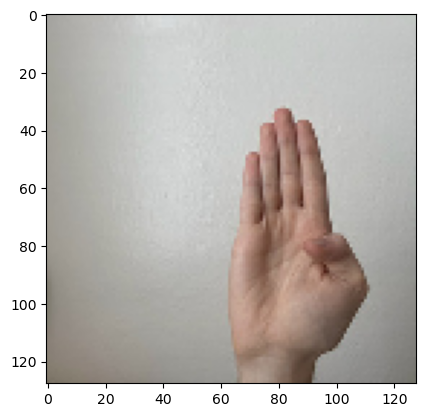

In [6]:
transform = Compose([
    Resize(128, interpolation=InterpolationMode.NEAREST),
    ToTensor(),
])

# load the image
image = transform(Image.open(f'{IMG_NAME}.png'))
plt.imshow(image.permute(1,2,0))

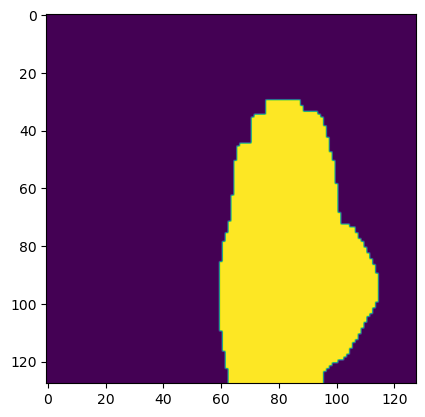

In [7]:
transform_mask_blur = Compose([
    Grayscale(),
    Resize(128, InterpolationMode.NEAREST),
    ToTensor(),
])

# widen the mask
mask_blur = transform_mask_blur(Image.open(f'gtFine/Test/{IMG_NAME}_gtFine_color.png'))

mask_blur = GaussianBlur(kernel_size=3)(mask_blur)
mask_blur = (mask_blur > 0).to(float)
mask_blur = GaussianBlur(kernel_size=3)(mask_blur)
mask_blur = (mask_blur > 0).to(float)

mask = mask_blur

plt.imshow(mask.permute(1,2,0))

## Compute Heatmaps

In [8]:
data = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)[None]

_, relevance_tp = get_relevance(model_tp, data, num_classes=24)
_, relevance_bl = get_relevance(model_bl, data, num_classes=24)

# ROF

In [9]:
def rof(heatmap: torch.FloatTensor, mask: torch.FloatTensor) -> int:
    heat_total = heatmap.sum().item()
    heat_inside = (heatmap * mask).sum().item()
    
    return heat_inside / heat_total

In [10]:
rof(relevance_tp, mask)

0.7844417483314742

In [11]:
rof(relevance_bl, mask)

0.6893057398744907